# 4th Week: Tutorial for Deep Learning with Audio
- Pitch classification
- Pitch regression
- Timbre classification


In [1]:
import torch
import torch.nn as nn
from math import pi
import IPython.display as ipd
import random
import matplotlib.pyplot as plt

In [ ]:
torch.__version__

'1.9.0+cu102'

## 1. Make audio dataset
- We will use `torch` instead of `numpy` 
- Generate audio with 
  - Random frequency
  - Random number of harmonics
  - Random amplitude of harmonics
  - Plus white noise with random amplitude

In [2]:
SR = 16000
def make_sine_wave(freq, amp, dur, sr):
  num_samples = dur * sr
  time_frame = torch.arange(num_samples)
  time_frame_sec = time_frame / sr
  return amp * torch.sin(2 * pi * freq * time_frame_sec)

def make_sine_wave_with_random_harmonics(freq, amp, dur, sr, num_harm=7):
  fund = make_sine_wave(freq,amp,dur,sr)
  for i in range(2, num_harm):
    fund += make_sine_wave(freq * i, amp*random.random()/i**(1+random.random()), dur, sr)
  return fund

def make_white_noise(amp, dur, sr):
  return torch.randn(dur*sr)*amp

def make_pitch_class_dataset(n_samples_per_pitch):
  pitches = [440., 466.2, 493.8, 523.3, 554.4, 587.3,
            622.3, 659.3, 698.5, 740., 784.0, 830.6]
  pitch_name = ['A', 'Bb', 'B', 'C', 'Db', 'D', 'Eb' ,'E', 'F', 'Gb', 'G', 'Ab']
  dataset = [make_sine_wave_with_random_harmonics(pitch, 0.3+random.random()/2, dur=3, SR, num_harm=3)+make_white_noise(random.random()*0.1, 3, SR) 
              for pitch in pitches for i in range(n_samples_per_pitch)]
  pitches = [i for i in range(len(pitch_name)) for j in range(n_samples_per_pitch)]
  dataset = torch.stack(dataset)
  pitches = torch.LongTensor(pitches)
  return dataset, pitches


def make_random_pitch_dataset(n_samples, pitch_range=(220,880)):
  min_pitch, max_pitch = pitch_range
  pitches = [random.randint(min_pitch,max_pitch) for i in range(n_samples)]
  dataset = [make_sine_wave_with_random_harmonics(pitch,0.3,3,SR)+make_white_noise(random.random()*0.2, 3, SR) for pitch in pitches]
  dataset = torch.stack(dataset)
  pitches = torch.Tensor(pitches)
  return dataset, pitches

dataset, pitches = make_pitch_class_dataset(100)


### torch.Tensor
torch의 기본적인 데이터 형식

- gradient를 자동으로 계산

In [52]:
alist = [[1,2,3],[4,5,6],[7,8,9]]
atensor = torch.Tensor(alist)


ValueError: ignored

### torch.Tensor vs For loop

In [4]:
dataset.shape

torch.Size([1200, 48000])

### 1-1 Shuffle Dataset and Label in random order

### 1.1 Monitor dataset
1. Select random samples from dataset
2. Play the audio samples of the selected sample

In [16]:
data_idx = random.randint(0, len(dataset)-1) #start, end  
data_sample = dataset[data_idx, :] 
ipd.display(ipd.Audio(data_sample, rate=SR))
print(f'Note pitch is {pitches[data_idx]}')

Note pitch is 9


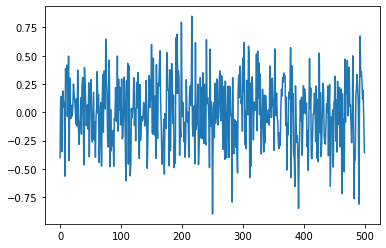

In [15]:
# plot white noise
noise = make_white_noise(amp=0.3, dur=3, sr=SR)
plt.plot(noise[:500])

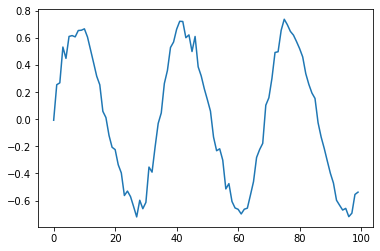

In [21]:
# 100번째 데이터의 첫 1초
# 첫1초가 몇 오디오 샘플인지: sample_rate * second 

plt.plot(dataset[100, SR:48000])

피치 클래스는 클래스의 index로 표현.

In [48]:
torch.LongTensor([0,1,2,3,4])

tensor([0, 1, 2, 3, 4])

## 1.2 Make Spectrogram
- 오디오 샘플을 처리하는 방법을 신경망이 학습하기 위해서는 데이터가 너무 많이 필요함
- 오디오 데이터는 STFT를 통해 Spectrogram으로 변환하는 것이 일반적

- Spectrogram

- MelSpectrogram

In [22]:
# install torchaudio
!pip install torchaudio==0.9.0
import torchaudio

     |████████████████████████████████| 1.9 MB 5.4 MB/s 


In [53]:
spec_converter_a = torchaudio.transforms.MelSpectrogram(sample_rate=SR, n_fft=4192, f_min=200, f_max=3200, n_mels=48)
# spec_converter_b = torchaudio.transforms.MelSpectrogram(sample_rate=SR, n_fft=4192, f_min=200, f_max=3200, n_mels=96)

spec_a = spec_converter_a(dataset)
# spec_b = spec_converter_b(dataset)



In [54]:
amp_to_db_converter = torchaudio.transforms.AmplitudeToDB()
spec_a = amp_to_db_converter(spec_a)
# spec_b = amp_to_db_converter(spec_b)

In [25]:
spec_a.shape

torch.Size([1200, 48, 23])

#### Plot Spectrogram
- Plot 2D spectrogram with `plt.imshow`
  - add `origin='lower'` to inverse y axis
- Plot 1D spectrum from a single frame of 2D spectrogram

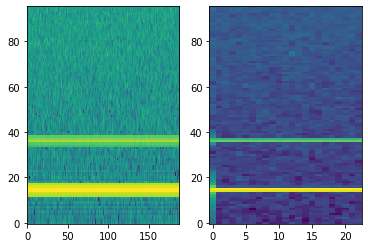

In [44]:
plt.subplot(1,2,1)
plt.imshow(spec_a[0], origin='below', aspect='auto', interpolation='nearest')
plt.subplot(1,2,2)
plt.imshow(spec_b[0], origin='below', aspect='auto', interpolation='nearest')

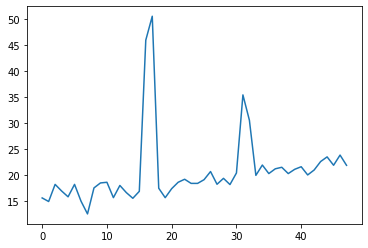

In [76]:
# spec_a의 차원축: 데이터샘플 x 주파수 축 x 시간 축
plt.plot(spec_a[0, :, 20])
# plt.plot(spec_b[0, :, 5])

In [36]:
data_sample = spec_a[0]
torch.max(data_sample), torch.median(data_sample)

(tensor(17.7162), tensor(14.3701))

### Shuffle dataset

In [57]:
rand_ids = torch.randperm(dataset.shape[0])

In [61]:
rand_ids[:10]

tensor([1181,  930, 1041,  288,  559, 1004, 1104, 1053,  327,  850])

In [72]:
spec_a = spec_a[rand_ids]
pitches = pitches[rand_ids]

### 1.3 Split Dataset
- Training set: Dataset to train model parameters
- Test set: Dataset to test how the trained model works with unseen data

In [73]:
train_ratio = 0.8
slice_idx = int(len(dataset) * 0.8)  #len(dataset) == dataset.shape[0]
train_set = spec_a[:slice_idx]
test_set = spec_a[slice_idx:]
train_label = pitches[:slice_idx]
test_label = pitches[slice_idx:]

In [74]:
test_set.shape ## spectrogram datset의 shape: 데이터 샘플 X 주파수 X 시간

torch.Size([240, 48, 23])

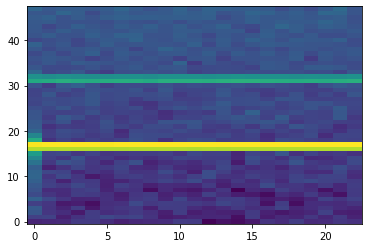

In [75]:
plt.imshow(train_set[0], aspect='auto', origin='below')

## 2. Make a Deep Neural Network Model
- Start with a simple model
- First Goal: make input and output right

스펙트로그램을 입력으로 받아서 이 소리가 12개의 음계중 어떤 음에 해당하는지를 맞추는 모델

분류 문제를 푸는 모델은, 각각의 클래스 (종류, 분류)에 해당하는 확률이 얼마인지를 반환하는 형태
- 즉 클래스 종류 수 만큼의 숫자를 출력해야함
  - 각 숫자는 해당 클래스의 확률을 의미함

In [78]:
class PitchClassifier(nn.Module):
  def __init__(self):
    super().__init__()
    self.layer = nn.Linear(in_features=48, out_features=12)
  
  def forward(self, x):
    return self.layer(x) ## == self.layer.forward(x)

pitch_classifier = PitchClassifier()
# pitch_classifier(train_set) == pitch_classifier.forward(train_set)

### 2-1 Test that the model can process our input
- Run with first 10 samples
- Handle spectrogram
  - Select only one frame
  - Use mean of entire time
  - Flatten every frame

In [80]:
# 한 시간 프레임만 잘라서 사용
train_set = train_set[:,:,5] #5번째 시간 프레임의 값만 사용
test_set = test_set[:,:,5]


In [85]:
# nn.module은 랜덤한 값으로 초기화
pitch_classifier.layer.weight[0]

tensor([ 0.0522, -0.0028,  0.0873,  0.0281,  0.0681,  0.0249, -0.1212,  0.0061,
         0.1170, -0.1158, -0.1401,  0.0439,  0.0101, -0.1333,  0.0455, -0.0662,
         0.0579,  0.0201,  0.0165, -0.1382, -0.1339, -0.0938, -0.1062, -0.0410,
        -0.0120, -0.0515, -0.0719, -0.0142, -0.0330, -0.0061, -0.0317, -0.0083,
        -0.0009, -0.0329, -0.0175, -0.0941,  0.0034,  0.1392, -0.0804,  0.0094,
         0.0654,  0.0997, -0.0980,  0.0578,  0.0931,  0.1046, -0.1117, -0.0341],
       grad_fn=<SelectBackward>)

In [89]:
test_output = pitch_classifier(train_set[:10])

### 2-2 Softmax
- We want to select only one pitch class
  - that has maximum probability
- Softmax is a function that 

In [90]:
test_output[0]

tensor([-9.4889, -0.9300,  2.6063, -1.4252,  6.4276, -3.3996, 10.6612, -2.4614,
        -2.8710,  9.9234, -6.8480, -0.6869], grad_fn=<SelectBackward>)

In [94]:
def softmax(x, dim):
  exp_v = torch.exp(x)
  sum_v = torch.sum(exp_v, dim=dim, keepdim=True)
  return exp_v / sum_v

tensor([[    0.0000,     0.0000,     0.0002,     0.0000,     0.0097,     0.0000,
             0.6698,     0.0000,     0.0000,     0.3203,     0.0000,     0.0000],
        [    0.0000,     0.0000,     0.0000,     0.0000,     1.0000,     0.0000,
             0.0000,     0.0000,     0.0000,     0.0000,     0.0000,     0.0000],
        [    0.0000,     0.0000,     0.0066,     0.0000,     0.0121,     0.0000,
             0.0000,     0.9812,     0.0000,     0.0000,     0.0000,     0.0000],
        [    0.0000,     0.0000,     0.0000,     0.0000,     0.8815,     0.0000,
             0.0000,     0.0000,     0.0000,     0.1185,     0.0000,     0.0000],
        [    0.0000,     0.0000,     0.0000,     0.0000,     0.1051,     0.0000,
             0.0000,     0.0000,     0.0000,     0.8948,     0.0000,     0.0001],
        [    0.0000,     0.0000,     0.0000,     0.0000,     0.9998,     0.0000,
             0.0000,     0.0000,     0.0000,     0.0002,     0.0000,     0.0000],
        [    0.0000,  

### 2-3 Loss
- Loss has to be zero if the prediction is perfect
- Loss has to be increased if the prediction gets worse
  - In pitch classification, we have only one correct class among 12 classes
    - Negative Log Likelihood with softmax

In [95]:
train_label[:10]

tensor([11,  9, 10,  2,  5, 10, 11, 10,  3,  8])

In [96]:
torch.arange(20)

tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19])

In [100]:
def get_nll_loss(pred, target):
  # prediction은 softmax 결과값
  prediction_for_target_class = pred[torch.arange(len(pred)), target]
  return torch.mean(-torch.log(prediction_for_target_class))

loss = get_nll_loss(softmax(test_output, -1), train_label[:10])

#### Backpropagation
- `loss.backward()` do backpropagation in `torch`
- The gradient of every parameters that was included in loss calculation will be calculated

In [101]:
pitch_classifier.layer.weight.grad

In [102]:
loss.backward()

In [ ]:
pitch_classifier.layer.weight.grad

### 2-4 Optimizer
- Optimizer helps to update neural network parameters
- There are various types of optimizers
- Most usual choice would be Adam
<img src=https://github.com/Jaewan-Yun/optimizer-visualization/raw/master/figures/movie9.gif>

In [104]:
optimizer = torch.optim.Adam(pitch_classifier.parameters(), lr=0.001)

#### Check optimizer works

In [106]:
pitch_classifier.layer.weight[0]

tensor([ 0.0522, -0.0028,  0.0873,  0.0281,  0.0681,  0.0249, -0.1212,  0.0061,
         0.1170, -0.1158, -0.1401,  0.0439,  0.0101, -0.1333,  0.0455, -0.0662,
         0.0579,  0.0201,  0.0165, -0.1382, -0.1339, -0.0938, -0.1062, -0.0410,
        -0.0120, -0.0515, -0.0719, -0.0142, -0.0330, -0.0061, -0.0317, -0.0083,
        -0.0009, -0.0329, -0.0175, -0.0941,  0.0034,  0.1392, -0.0804,  0.0094,
         0.0654,  0.0997, -0.0980,  0.0578,  0.0931,  0.1046, -0.1117, -0.0341],
       grad_fn=<SelectBackward>)

In [107]:
optimizer.step()

In [108]:
pitch_classifier.layer.weight[0]

tensor([ 0.0513, -0.0037,  0.0864,  0.0273,  0.0672,  0.0240, -0.1222,  0.0051,
         0.1160, -0.1167, -0.1410,  0.0430,  0.0093, -0.1343,  0.0446, -0.0671,
         0.0569,  0.0191,  0.0156, -0.1392, -0.1348, -0.0947, -0.1072, -0.0419,
        -0.0129, -0.0524, -0.0729, -0.0151, -0.0340, -0.0071, -0.0326, -0.0093,
        -0.0019, -0.0339, -0.0184, -0.0950,  0.0024,  0.1382, -0.0813,  0.0085,
         0.0645,  0.0987, -0.0989,  0.0568,  0.0922,  0.1036, -0.1126, -0.0350],
       grad_fn=<SelectBackward>)

In [109]:
test_output = pitch_classifier(train_set[:10])
loss = get_nll_loss(softmax(test_output, dim=-1), train_label[:10])
print(loss)

tensor(16.4165, grad_fn=<MeanBackward0>)


### 2-5 Make iteration loop

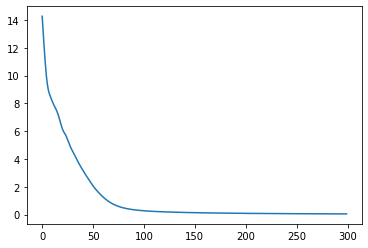

In [110]:
loss_tracker  = []

for i in range(300):
  optimizer.zero_grad()
  pred = pitch_classifier(train_set)
  pred = softmax(pred, dim=-1)
  loss = get_nll_loss(pred, train_label)
  loss.backward()
  optimizer.step()
  loss_tracker.append(loss.item())

plt.plot(loss_tracker)


### 2-6 Test the result
- `with torcn.no_grad():` makes following codes runs without tracking gradient

## Pitch Regression

## 2. Make torch Dataset